**Activation functions**  
A nonlinearity $\sigma$ to be applied to each of the hidden units after each layer's linear transformation

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable

def xyplot(x, y, name):
    x = x.detach().numpy()  # convert variable requiring grad to numpy
    y = y.detach().numpy()
    plt.plot(x, y)
    plt.xlabel("x")
    plt.ylabel(name + '(x)')

ReLU function retains only positive elements and discards negative elements (setting those nodes to 0)   
$$\mathrm{ReLU}(z) = \max(z, 0)$$

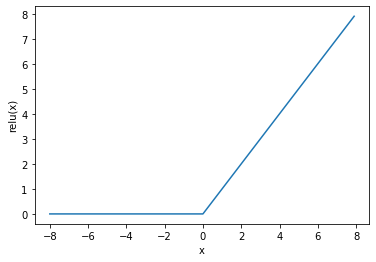

In [29]:
x = Variable(torch.arange(-8.0, 8.0, 0.1, dtype=torch.float32).reshape(-1, 1), requires_grad=True)
y = nn.functional.relu(x)
xyplot(x, y, "relu")

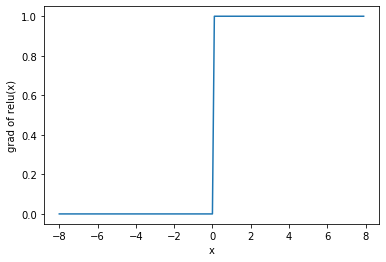

In [30]:
y.backward(torch.ones_like(x), retain_graph=True)  # grad can be implicitly created only for scalar outputs
xyplot(x, x.grad, "grad of relu")

$$\mathrm{sigmoid}(x) = \frac{1}{1 + \exp(-x)}$$

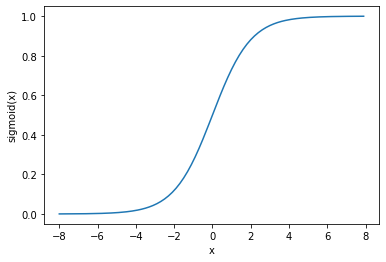

In [33]:
x = Variable(torch.arange(-8.0, 8.0, 0.1, dtype=torch.float32).reshape(-1, 1), requires_grad=True)
y = torch.sigmoid(x)
xyplot(x, y, "sigmoid")

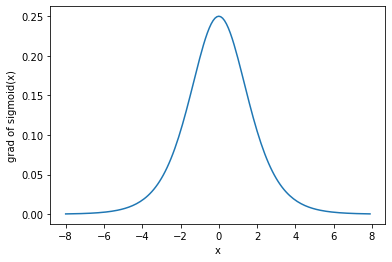

In [34]:
y.backward(torch.ones_like(x))
xyplot(x, x.grad, "grad of sigmoid")

$$\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}$$

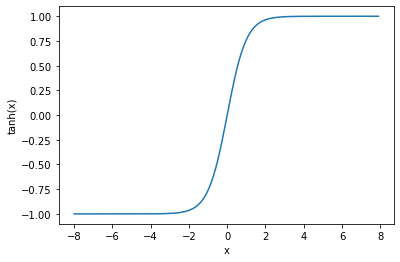

In [35]:
x = Variable(torch.arange(-8.0, 8.0, 0.1, dtype=torch.float32).reshape(-1, 1), requires_grad=True)
y = torch.tanh(x)
xyplot(x, y, "tanh")

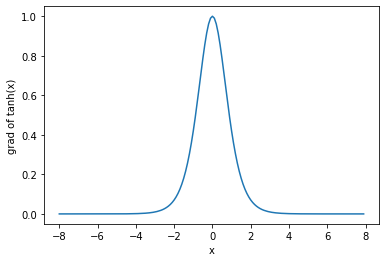

In [36]:
y.backward(torch.ones_like(x), retain_graph=True)
xyplot(x, x.grad, "grad of tanh")

In [37]:
# previously defined values and functions
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="./", train=True, download=False, transform=trans)
mnist_test = torchvision.datasets.FashionMNIST(root="./", train=False, download=False, transform=trans)

batch_size = 256
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=0)

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        acc_sum += (net(x).argmax(dim=1) == y).sum().item()
        n += y.size()[0]
    return acc_sum / n

def get_text_labels(labels):
    tlabels = mnist_train.classes
    return [tlabels[int(i)] for i in labels]

def show_img(images, labels):
    _, fig = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, label in zip(fig, images, labels):
        f.imshow(img.reshape(28, 28).numpy())
        f.set_title(label)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        
num_epochs, lr = 10, 0.1

def train(net, loss, num_epochs, lr=None):
    optimizer = torch.optim.SGD(net.parameters(), lr, momentum=0.9)
    # minibatch for efficient performance
    batch_size = 256
    train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=0)
    
    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
        for x, y in train_iter:
            optimizer.zero_grad()
            y_hat = net(x)
            l = loss(y_hat, y).mean()
            l.backward()
            optimizer.step()

            train_loss_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.size()[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch {}, loss {:.4f}, train accuracy {:.3f}, test accuracy {:.3f}'.format(epoch + 1, train_loss_sum / n, train_acc_sum / n, test_acc))

In [10]:
# implementation from scratch
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.w1 = nn.Parameter(torch.randn(784, 256, requires_grad=True) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(256, requires_grad=True))
        self.w2 = nn.Parameter(torch.randn(256, 10, requires_grad=True) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(10, requires_grad=True))
        
    def forward(self, x):
        x = x.reshape(-1, 784)
        h = self.relu(torch.mm(x, self.w1) + self.b1)
        return (torch.mm(h, self.w2) + self.b2)
    
    def relu(self, s):
        zm = torch.zeros_like(s)
        return torch.max(s, zm)
    
net = Net()
loss = nn.CrossEntropyLoss()

In [11]:
train(net, loss, num_epochs, lr)

epoch 1, loss 0.0026, train accuracy 0.762, test accuracy 0.838
epoch 2, loss 0.0016, train accuracy 0.853, test accuracy 0.838
epoch 3, loss 0.0014, train accuracy 0.866, test accuracy 0.860
epoch 4, loss 0.0013, train accuracy 0.875, test accuracy 0.868
epoch 5, loss 0.0013, train accuracy 0.881, test accuracy 0.869
epoch 6, loss 0.0012, train accuracy 0.885, test accuracy 0.873
epoch 7, loss 0.0012, train accuracy 0.890, test accuracy 0.873
epoch 8, loss 0.0011, train accuracy 0.892, test accuracy 0.871
epoch 9, loss 0.0011, train accuracy 0.897, test accuracy 0.880
epoch 10, loss 0.0011, train accuracy 0.900, test accuracy 0.866


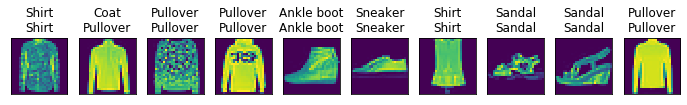

In [12]:
for x, y in test_iter:
    break

true_labels = get_text_labels(y.numpy())
pred_labels = get_text_labels(net(x).argmax(dim=1).numpy())
titles = [t + '\n' + p for t, p in zip(true_labels, pred_labels)]
show_img(x[-10:], titles[-10:])
# MLP doing better than softmax

In [13]:
# concise implementation
class Net(torch.nn.Module):
    def __init__(self, num_inputs=784, num_outputs=10, num_hiddens=256, is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hiddens = num_hiddens
        
        self.linear1 = nn.Linear(num_inputs, num_hiddens)
        self.linear2 = nn.Linear(num_hiddens, num_outputs)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.reshape(-1, self.num_inputs)
        h1 = self.relu(self.linear1(x))
        return self.linear2(h1)
    
net = Net()
net

Net(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

In [14]:
train(net, loss, num_epochs, lr)

epoch 1, loss 0.0023, train accuracy 0.787, test accuracy 0.840
epoch 2, loss 0.0016, train accuracy 0.852, test accuracy 0.847
epoch 3, loss 0.0014, train accuracy 0.867, test accuracy 0.856
epoch 4, loss 0.0013, train accuracy 0.875, test accuracy 0.859
epoch 5, loss 0.0013, train accuracy 0.882, test accuracy 0.866
epoch 6, loss 0.0012, train accuracy 0.883, test accuracy 0.862
epoch 7, loss 0.0012, train accuracy 0.889, test accuracy 0.874
epoch 8, loss 0.0011, train accuracy 0.893, test accuracy 0.876
epoch 9, loss 0.0011, train accuracy 0.896, test accuracy 0.867
epoch 10, loss 0.0011, train accuracy 0.900, test accuracy 0.875


Optimizing parameters:   
learning rate; iterations; number of hidden layers; number of units per layer...